In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import requests
import json

from scipy.stats import entropy as entr
from numpy.linalg import norm
from pandas.tseries.offsets import MonthEnd
from pandas_datareader import data, wb


import statsmodels.formula.api as sm

import seaborn as sns
from  matplotlib import pyplot as plt
%matplotlib inline

sns.set_style("white")
sns.set_palette("RdBu_r")

In [2]:
from time import sleep
import datetime as dt

In [3]:
def formatPythonList(string):
    return  [t.replace("{","").replace("}","").replace(",","").replace("*^","e") 
             for t in string.fields()[0]]


def mathematicaMaxEnt(list1, list2, norm=1):
    l1 = "List"+str(list1)
    l2 = "List"+str(list2)

    maxent = !./maxent.sh "$l1" "$l2" "$norm"
    maxent = formatPythonList(maxent)

    return np.array(map(np.float, maxent)).reshape(len(list1), len(list2))

In [4]:
def JSD(P, Q):
    p = np.array(P)
    q = np.array(Q)
    if len(p.shape) > 1:
        p = p.flatten()
        q = q.flatten()
    m = 0.5 * (p + q)
    return 0.5/np.log(2.) * (entr(p, m) + entr(q, m))


def KLD(P, Q):
    p = np.array(P)
    q = np.array(Q)
    if len(p.shape) > 1:
        p = p.flatten()
        q = q.flatten()
    return entr(p, q)


def S_KLD(X, Y, t0=None, t1=None):
    x = X.loc[t0:t1]
    y = Y.loc[t0:t1]
    
    x_bins = x.value_counts(True, True, True).sort_index().values.tolist()
    y_bins = y.value_counts(True, True, True).sort_index().values.tolist()
    
    maxent_distr = mathematicaMaxEnt(x_bins, y_bins) 
    emp_distr = pd.crosstab(x, y, normalize=True)
    
    return KLD(emp_distr, maxent_distr)


def rescaleRange(x):
    return 1 - np.exp(-2.*x)

def stringCSV(name, *arg):
    string = name
    if len(arg) > 0:
        string = string + "_"
        arg = [a for a in arg if a is not None]
        arg = map(str, arg)
        
    return string + "_".join(arg) + ".csv"

In [5]:
class comtradeAPI(object):
    def __init__(self):
        self._url = "http://comtrade.un.org/api/get"
        
        self._callstat = pd.DataFrame(data=[pd.datetime.now()],
                                      columns=["calltime"])
        self._maxcalls = 98 
        

    def _timing_wrapper(func):
        from time import sleep
        
        def wrapper(*args, **kwargs):
            sleep(1)
            return func(*args, **kwargs)
        return wrapper
            
        
    @_timing_wrapper
    def get_data(self, **params):
        url = self._url
        
        try:
            response = requests.get(url, params=params)
        except requests.RequestException as e:
            print (str(e))
        
        content = response.content.decode('utf-8')
        try:
            content = json.loads(content)
        except:
            pass
        
        return content

In [6]:
class financialData(object):
    
    def __init__(self):
        pass
    
    def get_stock(self, symbol="SPY", source="iex", start="2017-01-01", end="2017-12-31", resample="Q"):
        df = data.DataReader(symbol, source, start, end).loc[:, "close"].to_frame(symbol)
        df.index = pd.to_datetime(df.index)
        if resample == None:
            return df
        else:
            return df.resample(resample).last()
        
        
    
    def get_oil(self, start="2017-01-01", end="2017-12-31", resample="Q"):
        oil_df = pd.read_excel("http://www.eia.gov/dnav/pet/hist_xls/RCLC1d.xls", 
                               sheet_name=1, header=2, index_col=0, parse_dates=True)
        oil_df.columns = ["Oil_Price"]
        
        return oil_df.loc[start:end].resample(resample).last()

In [7]:
fd = financialData()

In [9]:
ct = comtradeAPI()

In [10]:
def lookupISO(export=True):
    ct = comtradeAPI()
    fx_dict = {"AUS":"AUD", "AUT":"EUR", "BEL":"EUR", "CAN":"CAD", "CHE":"CHF", "CYP":"EUR", 
               "DEU":"EUR", "ESP":"EUR", "EST":"EUR", "FIN":"EUR", "FRA":"EUR", "GBR":"GBP",
               "GRC":"EUR", "IRL":"EUR", "ITA":"EUR", "JPN":"JPY", "LTU":"EUR", "LUX":"EUR",
               "LVA":"EUR", "MEX":"MXN", "MLT":"EUR", "NLD":"EUR", "NOR":"NOK", "NZL":"NZD", 
               "SGP":"SGD", "SWE":"SEK", "PRT":"EUR", "SVK":"EUR", "SVN":"EUR", "USA":"USD"}
    
    # Dummy lookup of all trading relationships in two years to capture the UN Comtrade country codes
    lookup = ct.get_data(ps="2008,2016", r="36", p="All", fmt="json")
    lookup_df = pd.DataFrame.from_dict(lookup["dataset"]).loc[:, ["ptCode", "pt3ISO"]].drop_duplicates()
    lookup_df = lookup_df.rename(columns={"ptCode":"UN"})

    # Create column with currency codes belonging to each country
    lookup_df.loc[:, "FX"] = lookup_df.loc[:, "pt3ISO"].map(iso_dict)
    
    if export:
        lookup_df.to_csv("iso_codes.csv")
    
    return lookup_df


try:
    iso_codes = pd.read_csv("iso_codes.csv", index_col=0).dropna().set_index("pt3ISO").to_dict()
except:
    lookup_df = lookupISO()

In [11]:
df = pd.read_csv("data/M10_2005_2018_returns_filtered.csv", 
                 engine='c', index_col='time', parse_dates=True)

symbols = ["EUR_AUD", "EUR_CAD", "EUR_CHF", "EUR_EUR", "EUR_GBP", "EUR_JPY", 
           "EUR_MXN", "EUR_NOK", "EUR_NZD", "EUR_SEK", "EUR_SGD", "EUR_USD", "EUR_ZAR"]

In [19]:
np.outer([2,3,4],[1,2,3])

array([[ 2,  4,  6],
       [ 3,  6,  9],
       [ 4,  8, 12]])

In [63]:
class CurrencySet(object):
    def __init__(self, df, symbols=None, t0="20080101", t1=None):
        self._returns = df.loc[t0:t1, symbols]
        self._no = len(self._returns.columns)

        self._ranks = self._returns.rank(axis=1, numeric_only=True, method='first')
        self._ranks = 2*self._ranks.applymap(np.int) - (self._no+1)

        self._curr = [_c[4:] for _c in self._ranks.columns]
        self._ranks.columns = self._curr
        
        self._bincounts = self._ranks.apply(pd.Series.value_counts, args=(True,True,True,))

    
    def _KLD(self, P, Q):
        p = np.array(P)
        q = np.array(Q)
        if len(p.shape) > 1:
            p = p.flatten()
            q = q.flatten()
        return entr(p, q)


    def _S_KLD(self, X, Y, maxent_func=mathematicaMaxEnt, t0=None, t1=None):
        x = X.loc[t0:t1]
        y = Y.loc[t0:t1]

        x_bins = x.value_counts(True, True, True).sort_index().values.tolist()
        y_bins = y.value_counts(True, True, True).sort_index().values.tolist()

        maxent_distr = maxent_func(x_bins, y_bins) 
        emp_distr = pd.crosstab(x, y, normalize=True).as_matrix()
        
        return self._KLD(emp_distr, maxent_distr)
    
    
    def _calc_KLD(self, df, no, lag):
        curr = self._curr
        # If no lag, then calculate for i, j, and i!=j
        # Else, calculate all i, j pairs, but use symmetry.
        # To do that, create matrix where all pairs to be calculated are np.nan
        if lag > 0:
            kld_df = pd.DataFrame(data=np.empty((no,no,)).fill(False),
                                  index=[c+ "_predictor" for c in curr], columns=curr)
            maxent_func = np.outer
        else:
            kld_df = pd.DataFrame(data=np.identity(no),
                                  index=curr, columns=curr).replace(0, False) - 1
            maxent_func = mathematicaMaxEnt
        
        for i in range(no):
            for j in range(no):
                if kld_df.iloc[i,j]:
                    df_i, df_j = self._predictor(df.iloc[:, [i,j]], lag) 
                    kld_df.iloc[i,j] = rescaleRange(self._S_KLD(df_i, df_j, maxent_func))
                else:
                    pass
                
                if lag == 0:
                    kld_df.iloc[j,i] = kld_df.iloc[i,j]
        
        return kld_df

    
    def _predictor(self, df, lag):
        if lag > 0:
            c1, c2 = df.columns
            df_predictor = pd.merge(df.iloc[:, 0].shift(lag).to_frame(c1 + "_predictor"),
                              df.iloc[:, 1].to_frame(c2), 
                              left_index=True, right_index=True)
            df_predictor = df_predictor.dropna().applymap(np.int)
        else:
            df_predictor = df
            
        return df_predictor.iloc[:, 0], df_predictor.iloc[:, 1]

        
    def _timeslicer(self, year, q):
        # Allow to evaluate quarterly. 
        # If no quarter is specified, select whole year
            
        if year != None:
            y1, y2 = str(year)
                
        else:
            y1, y2 = str(self._ranks.index[0].year), str(self._ranks.index[-1].year)
            q = None
            
        if q != None:
            q0, q1 = '{:02d}'.format(3*q-2), '{:02d}'.format(3*q)
        else:
            q0, q1 = "01", "12"
            
        
        loc0 = pd.to_datetime(y1 + "-" + q0 + "-01")
        loc1 = pd.to_datetime(y2 + "-" + q1) + MonthEnd(1)
        
        return loc0, loc1
    
    
    
        
    def get_ranks(self):
        return self._ranks
    
    
    def get_bincounts(self):
        return self._bincounts
    
    
    def get_KLD_matrix(self, year=None, q=None, lag=0, export=True):
        # Number of currencies
        no = self._no
        
        loc0, loc1 = self._timeslicer(year, q)
    
        df = self._ranks.loc[loc0:loc1]
                
        # Calculate Kullback-Leibler divergence for all pairs of empirical and theoretical 
        # bivariate distributions and rescale to [0,1].
        kld_df = self._calc_KLD(df, no, lag)
        
        # After calculating one triangle of matrix, mirror along diagonal and 
        # set diagonal to np.nan
        kld_df = kld_df.replace(0, np.nan)
        
        if export == True:
            kld_df.to_csv(stringCSV("KLD", no, year, q, "lag_"+str(lag)), index=True)
        else:
            pass
        
        return kld_df

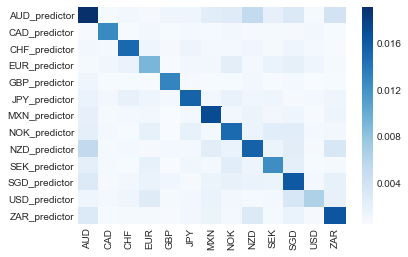

In [64]:
cs = CurrencySet(df, symbols)

sns.heatmap(cs.get_KLD_matrix(year=None, q=None, lag=1, export=False), cmap="Blues")